## Derek reply

However, I have a couple of quick questions: there is very clear structure in this field – in particular the loop that I called ‘Loop 1’, and that other have variously labelled as the ‘trombone’ or the ‘telephone’. So my question is this: what happens if you artificially remove this loop from your analysis? Do the results look significantly different?

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -1.453e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.430e+01 [aplpy.core]


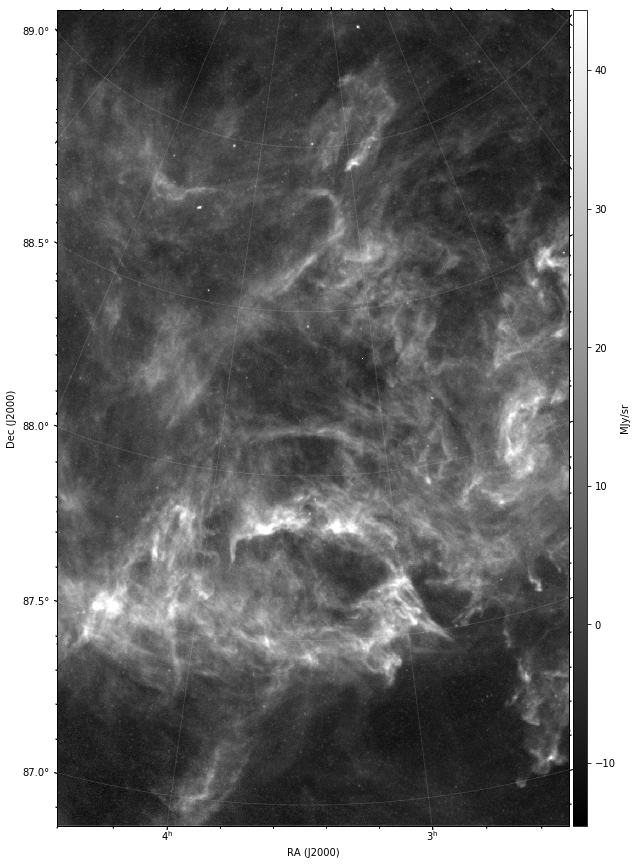

In [2]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/polaris-250_cut_saxfree.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'MJy/sr')

In [4]:
from pywavan import fan_trans, apodize, padding, powspec

In [5]:
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/polaris-250_cut_saxfree.fits'

HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

newsize = np.array([1800,1800])

#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

#Apodization for Fourier power spectrum
tapper = apodize(nb,na,0.97)
imt = imzm *tapper
imr = padding(imt,newsize[1],newsize[0])

#Beam Power spectrum
HDUb = fits.open("/Users/robitaij/postdoc/Herschel/beams/empiral_spire_beam_250.fits")
beam = HDUb[0].data
beamr = padding(beam,newsize[1],newsize[0])
tab_k, spec_beam = powspec(beamr, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, qdyn=False, cutpad=False)
#del Bwt,BS11a,Bq
#BS1an = BS1a / BS1a[4]
#BS1an[:4] = 1.0
#np.save("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_BS1an_saxfree.npy",BS1an)
BS1an = np.load("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_BS1an_saxfree.npy")

In [13]:
#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Put in Jy^2/sr
spec_k = spec_k*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12

#Set a list of q
#q=[]
#q=[2.5]*26

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, apodize= 0.97, arrdim = newsize, cutpad=True)
#np.save("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_wav_k_saxfree.npy",wav_k)
#np.save("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_S1a_saxfree.npy",S1a)
#np.save("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_wt_saxfree.npy",wt)
#np.save("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_S11a_saxfree.npy",S11a)
wav_k = np.load("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_wav_k_saxfree.npy")
S1a = np.load("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_S1a_saxfree.npy")
wt = np.load("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_wt_saxfree.npy")
S11a = np.load("/Users/robitaij/postdoc/segment_paper/comments/derek/polaris_S11a_saxfree.npy")

#Convertion in Jy^2 sr^-1
S1a = S1a*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12

In [14]:
M = wav_k.shape[0]

S1a[0,:] = np.mean(S11a[0:M,600:,:],axis=(1,2))
S1a[1,:] = np.mean(S11a[M:2*M,600:,:],axis=(1,2))
S1a[2,:] = np.mean(S11a[2*M:3*M,600:,:],axis=(1,2))

#Convertion in Jy^2 sr^-1
S1a = S1a*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12

In [15]:
Noise = np.mean(spec_k[(tab_k >=4.) & (tab_k<=5.)])
print("Noise=", Noise)

Noise= 253.9736991988103


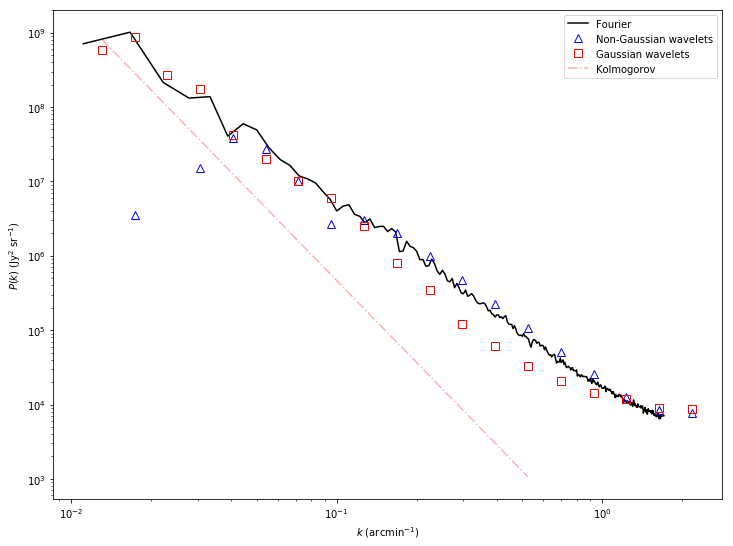

In [16]:
limF = np.where((tab_k > 1e-2) & (tab_k < 3.) & (spec_k > 10.**3))

#Kolmogorov power law
yKolmo = 1.e+2*wav_k**(-11./3.)

#Plot
plt.figure(figsize=(12,9))
plot(tab_k[limF], (spec_k[limF]-Noise)/spec_beamn[limF], color='black', linewidth=1.5, label='Fourier')
plot(wav_k[3:22], (S1a[1,3:22])/BS1an[3:22],'^', markersize = 8, markerfacecolor='none', markeredgecolor='blue', label='Non-Gaussian wavelets')
plot(wav_k[3:22], (S1a[2,3:22]-Noise)/BS1an[3:22],'s', markersize = 8, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelets')
plot(wav_k[3:17], yKolmo[3:17], linestyle='-.', color='red', linewidth=1.5, alpha=0.3, label='Kolmogorov')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$ (Jy$^2$ sr$^{-1}$)")
plt.legend()

INFO: Auto-setting vmin to -1.527e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.761e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.117e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.213e+01 [aplpy.core]


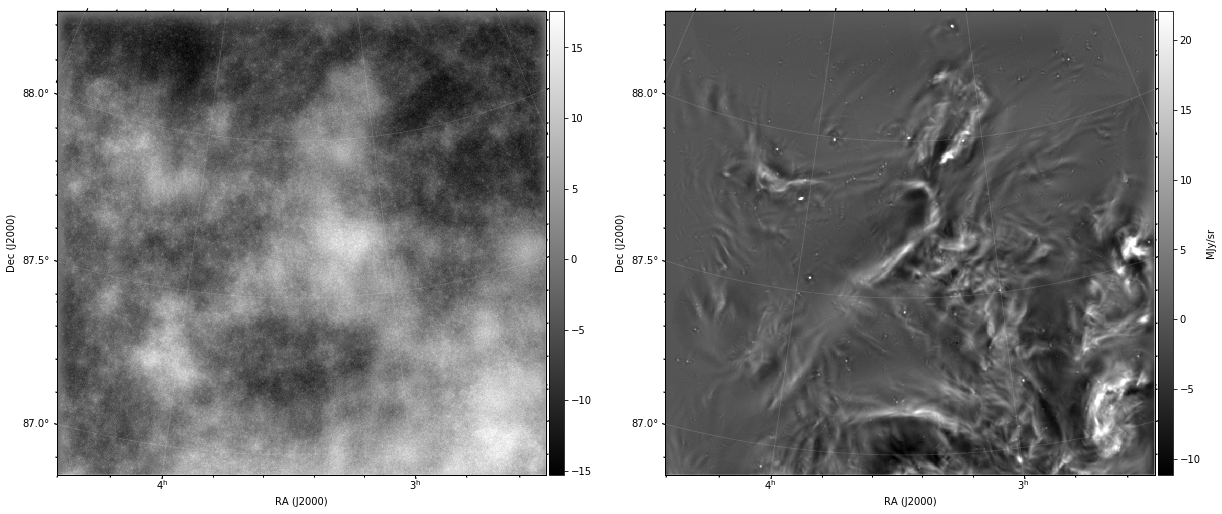

In [9]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,600:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,600:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_cohe_saxfree.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_gaussian_saxfree.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,20))

figfile = '/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_gaussian_saxfree.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_cohe_saxfree.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'MJy/sr')

### Correlation Gaussian/coherent

Text(0,0.5,'Coherent')

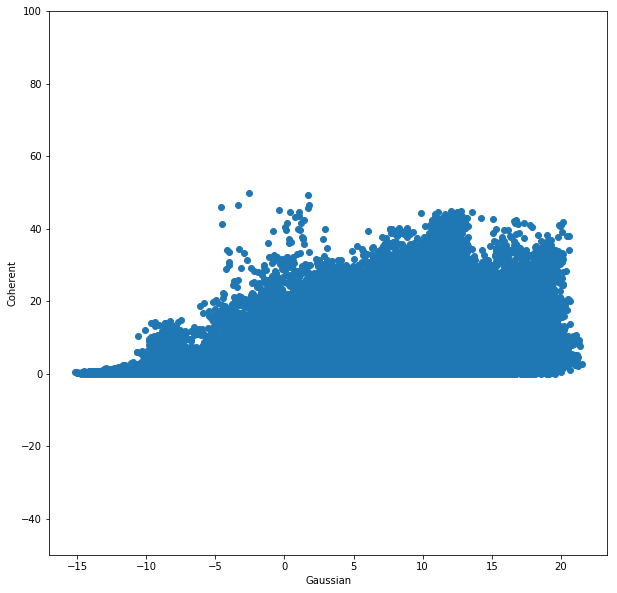

In [17]:
figure(figsize(10,10))
scatter(Gaussian[coherent > 0.].real,coherent[coherent > 0.].real)
ylim((-50,100))
xlabel('Gaussian')
ylabel('Coherent')

### Power spectra ratio

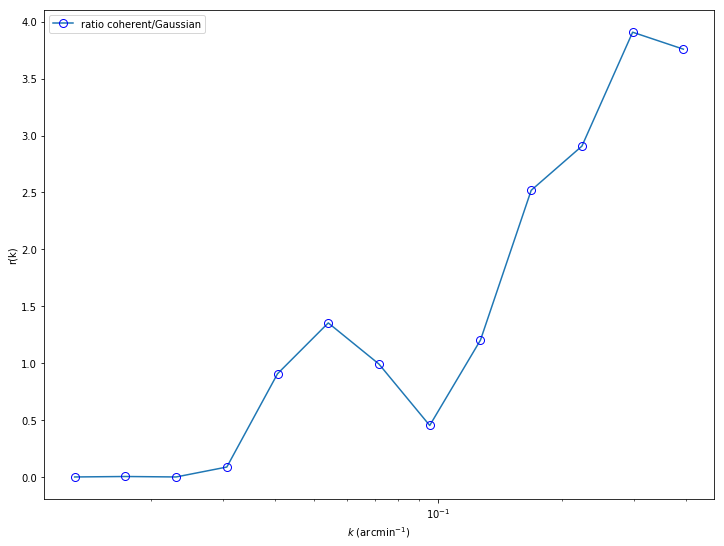

In [17]:
#Intermittency ratio
sole = (S1a[2,:]-Noise)
comp = S1a[1,:]
ratio = comp / sole

plt.figure(figsize=(12,9))
plot(wav_k[3:16], ratio[3:16], marker='o', markersize = 8, markerfacecolor='none', markeredgecolor='blue', linewidth=1.5, label='ratio coherent/Gaussian')
plt.xscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"r(k)")
plt.legend()

Reconstruction for the three spatial scales with an excess.

INFO: Auto-setting vmin to -4.716e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.622e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.499e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.407e+01 [aplpy.core]


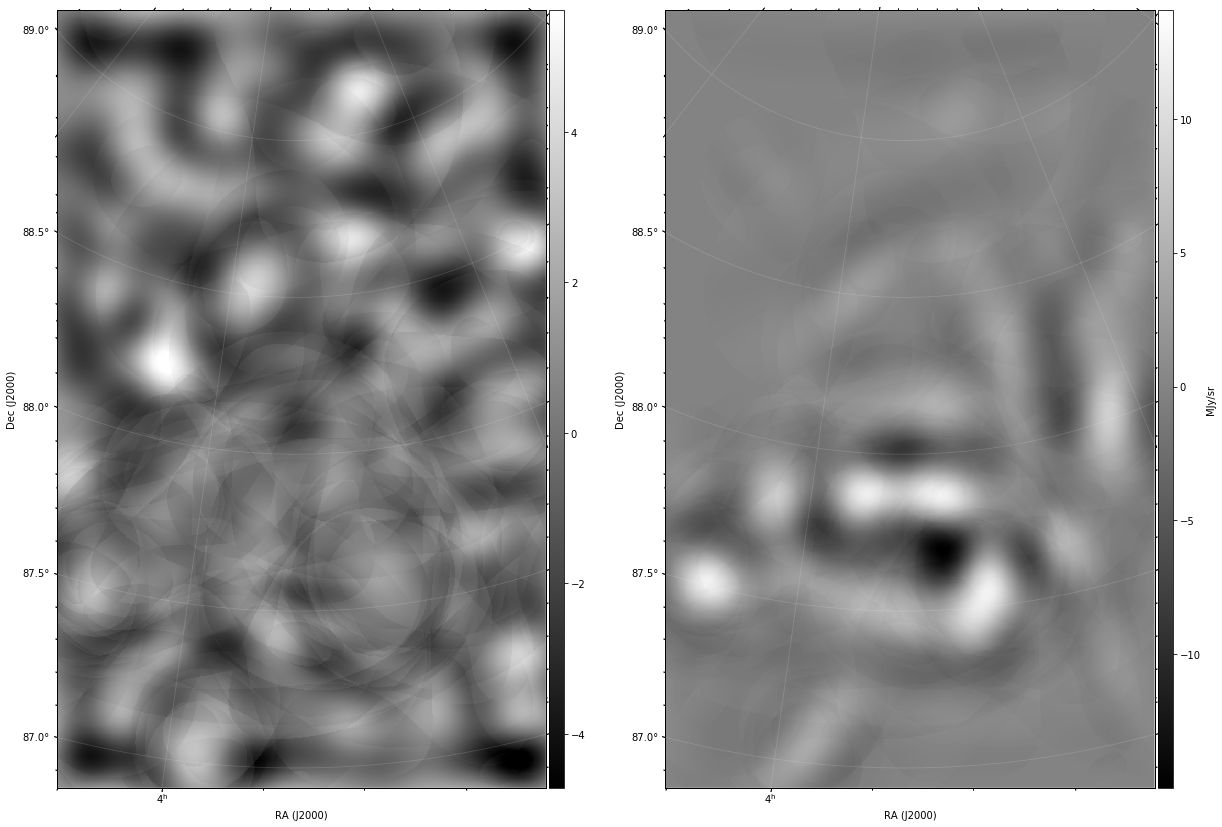

In [33]:
M = wav_k.shape[0]

cohe_bump = np.sum(wt[M+7:M+10,:,:],axis=0)
Gaus_bump = np.sum(wt[2*M+7:2*M+10,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_cohe_bump_saxfree.fits',\
            cohe_bump.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_gauss_bump_saxfree.fits',\
            Gaus_bump.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,20))

figfile = '/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_gauss_bump_saxfree.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/segment_paper/comments/derek/Polaris_cohe_bump_saxfree.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'MJy/sr')